# House Price I: A Comprehensive Explorative Data Analysis

### *Charlie Huang*

The kaggle competition, *House Price - Advanced Regression Techniques*, has been a very popular playground for exploring various ways of analyzing, modeling and visualizing dataset. Given a sample of houses with a wide range of features (~80) and their sale prices, the main task is to train a model to predict the sale price of new houses. I started this project with a purpose of exercising my newly acquired knowledge of data engineering and machine learning and exploring deep functionalities of python packages such as pandas, scikit-learn and seaborn.

This is the first module of a comprehensive exploration of the dataset, focusing on understanding the characteristics of the independent variables and their relations to the dependent variable. There are several reasons for performing a explorative data analysis (EDA):
- Build initial insights from the data and make better plans for more sophisticated modeling. 
- Detect anomalies within the data such as missing values, outliers and leaky features.
- Select and transform features to help improve the performance of machine learning algorithms.
- Help interpret and present the results from later analysis.

Here is a list of topics to cover within this module:
- Skewness
- Correlations between variables
- Data cleaning
- Outliers, Missing values and leaky features
- Encoding the categorical features: ordinal encoder, one-hot encoder, target encoder, leave-one-out encoder
- Dependence of the target variable on numerical, nominal and ordinal features
- Extract feature importance with a simple random forest model
- Some pandas and seaborn tricks of handling and visualizing data

Note that in this notebook, the "features" are often refered as "variables" and "columns".

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import skew, pearsonr

Load the training set. Have a quick look at the data using DataFrame.info(). The training data has 1460 samples and 81 features with a mixture of numerical and categorical features. A few features have NULL values that we will deal with later. 

In [227]:
sns.set(font_scale=1.2)

print("Loading data from train.csv.")
train = pd.read_csv("train.csv")
train.info()
m = train.shape[0]

Loading data from train.csv.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non

Among all the features from training set, some may not be applicable to the test set. In this dataset, YrSold, MoSold, SaleType, SaleCondition could be leaky features if we want to predict the sale price for houses that have not been sold yet. The trained model incorporates these information but the test data (houses not yet sold) do not have them.
In general, data leakage manifests in various ways and often leads to over-estimation of the expected model performance. 

Reference: https://insidebigdata.com/2014/11/26/ask-data-scientist-data-leakage/

In [182]:
vars_leaky = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition']

Always check distribution of the dependent variable:

Statistics of the target variable: 
--------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.880941


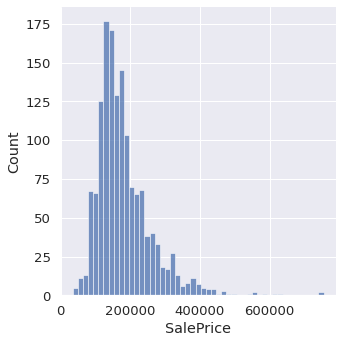

In [228]:
sns.displot(train['SalePrice'])
print("Statistics of the target variable: ")
print("--------------------------------")
print(train['SalePrice'].describe())
print("Skewness: %f" % (skew(train['SalePrice'])))

The output is apparently skewed (with a skewness value > 1). A common practice is to transform it to y = log(1+y). We will apply this transformation to skewed features later.

## Missing Data

Next, let's take a look at features with lots of missing data. I will refer these features as 'sparse' features. 
Often people simply drops those features that are mostly NULL. Here, I will quickly examine them and discard them if they are not strong indicators of y. 'Sparse' features might contain some critical information. For example, what if some houses used to be hosted by very famous people or have some bad rumors around (though this sample that we are working on doesn't have these kinds of information)? A single feature like these will likely dominate its sale price even though most houses may not have these features.

The following code examines:
1. The 10 most sparse features and what fraction of their values are missing.
2. Features with over 80% entries missing, what are they, are they of any interest? 
3. Visualize the missing values

I pick out 4 features to be dropped from the dataset (PoolQC, MiscFeature, Alley, Fence)

10 Most sparse features:
--------------------------------
PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

Feature with > 80% data missing: 
------------
Grvl    50
Pave    41
Name: Alley, dtype: int64
------------
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
------------
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64
------------
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64


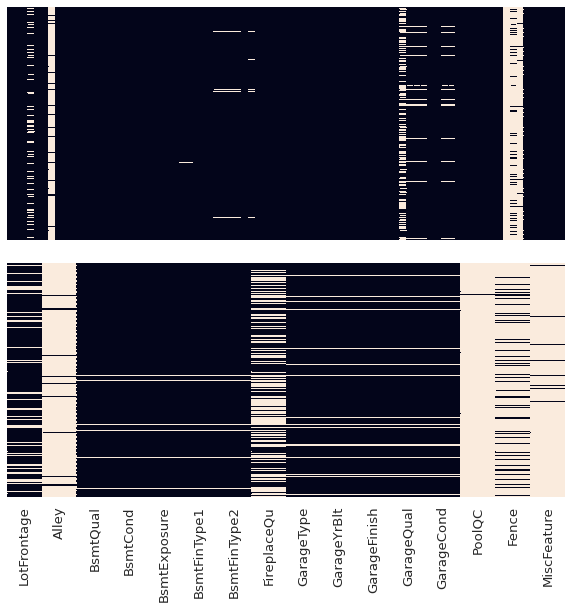

In [229]:
# One way to look at missing features
print("10 Most sparse features:")
print("--------------------------------")
print((1.0 - train.count() / m).sort_values(ascending=False)[:10])
print()

# I found this a very illustrative way of checking missing values
# Ref: (House Prices: EDA, Pipelines, GridSearchCV)
fig, axs = plt.subplots(2, 1, num="missing_train", figsize=(10, 10))
sns.heatmap(train.isna(), yticklabels=False, cbar=False, ax=axs[0])
axs[0].set_xticks([])
# Note that the figure above hides the labels of some features. One small update from myself is to only display features that have some (say, >1%) missing train:
features_with_missing_train = train.loc[:, train.count() < 0.99 * m]
sns.heatmap(features_with_missing_train.isna(), yticklabels=False, cbar=False, ax=axs[1])
fig.subplots_adjust(bottom=0.2, hspace=0.1)
    
# Select features with > 80% NaN
vars_sparse = train.loc[:, train.count() < 0.2 * m]
# Print out the values, are they important?
print("Feature with > 80% data missing: ")
for (col, val) in vars_sparse.iteritems():
    print("------------")
    print(val.value_counts())


## Correlations between numerical features

Next, let's look at the numerical features and how they correlate with the target y. Heatmap is a useful tool to visualize correlations between numerical features. Here are a few considerations when I made it:
1. The correlation matric to use. The default metric, the "pearson" correlation, has a few limitations, such as it measures the linear correlation, assumes normal distribution of variables and is sensitive to outliers. I prefer using rank based metrics such as the "spearman" correlation.
2. Re-order the features on the axes according to their correlations with the target y. Furthermore, I dropped features that are only weakly correlated with the target instead of showing all ~30 features here. 
3. Use a diverging color map to help picking out strong correlations.

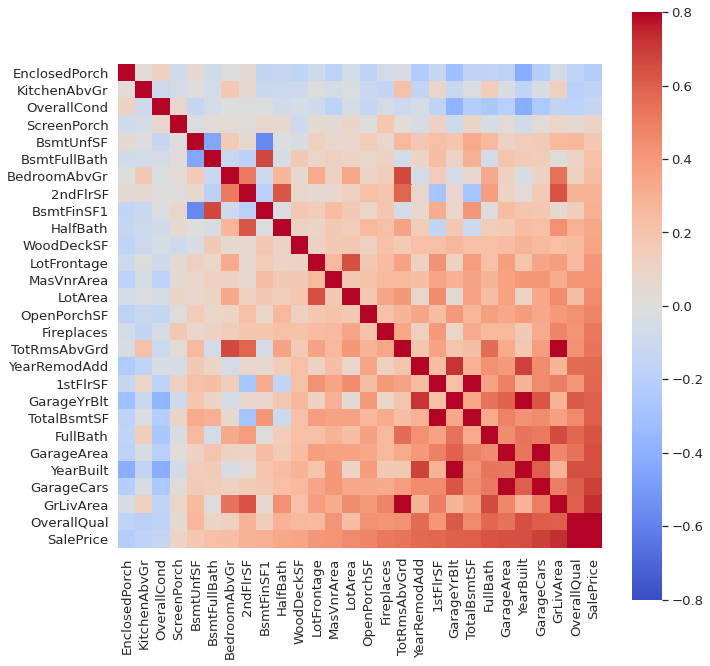

In [230]:
def study_variable_correlations(data, limit_score=0.2):
    '''
    Compute the correlation coeffcients between features and the target y and plot the correlation heatmap.
    
    Parameters:
    ---
    data: The pandas DataFrame that contains the data.
    limit_score: Only show features that strongly correlate with the target with a correlation coefficient larger than this value.
    '''

    # There are several metrics for measuring correlations. 
    # I will only use the Spearman correlation coefficients but keep the rest in a dataframe.
    corr_p = data.corrwith(data['SalePrice'])
    corr_k = data.corrwith(data['SalePrice'], method="kendall")
    corr_s = data.corrwith(data['SalePrice'], method="spearman")
    # Create pandas.dataFrame from pandas.Series
    corrs = {'pearson':corr_p, 'kendall':corr_k, 'spearman':corr_s}
    corrs = pd.DataFrame(corrs)

    corrs = corrs[abs(corrs['spearman']) > limit_score]
    # corrs = corrs.T.sort_values(by=0)
    corrs.sort_values(by='spearman', inplace=True)
    # Now move on to the correlation matrix
    corrmat = data[corrs.index].corr(method='spearman')
    # Trick 1: re-order the dataing data to follow the order of correlation
    # Trick 2: Use a diverging color map rather than the default
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    fig, ax = plt.subplots(1,1,figsize=(12,12), num="heatmap")
    sns.heatmap(corrmat, vmin=-0.8, vmax=0.8, square=True, cmap=cmap, ax=ax)
    fig.subplots_adjust(left=0.2, bottom=0.2)

corrs = study_variable_correlations(train, 0.1)

## Encoding Ordinal Categorical Features

Note however the heatmap does not contain categorical features. How do we know if a categorical feature is important to predicting y? Here I will divide categorical features into two classes:
1. Ordinal features. In these feature the categories are naturally ordered. For example, the feature "ExterQual" has 5 categories, "Ex", "Gd", "TA", "fa", "po", there are clearly ranked by goodness. One can encode ordinal features as numerics that increases with the rank order. Then using a rank based correlation metric one can include them in the heatmap as well.
2. Nominal features. In these features the categories are labeled without any particular order. For example, "Neighborhood" contains a list of names that do not seem to be related. Even though they might be ranked by things like the average income, the population density, etc., these information are simply not known from the data. Later we will see that "Neighborhood" is a relatively strong indicator of sale price, but it is difficult to visualize in a heatmap.

The following code hard codes the ordinal features from the data set. I keep the mappings between categories and their corresponding numerics in a separate .json file. The code loads the mappings into a python dictionary structure that can be directly applied to the pd.DataFrame. Here shows an example of a .json file of this kind:

{
    "ExterQual":
    {
	"Ex": 0,
	"Gd": 1,
	"TA": 2,
	"Fa": 3,
	"Po": 4	
    },
    "ExterCond":
    {
	"Ex": 0,
	"Gd": 1,
	"TA": 2,
	"Fa": 3,
	"Po": 4	
    }
}

In [149]:
import json
with open('ordinal.json',) as f:
    ordinal_feature_encoder = json.load(f)
print("Ordinal features to be encoded: ")
print("----------------")
print(ordinal_feature_encoder.keys())
print()

# Encode
train_derived = train.replace(ordinal_feature_encoder)

# Check one ordinal feature after encoding.
# Randomly pick 10 samples.
np.random.seed(26)
for i in np.random.randint(0, m, 10):
    print("%s : %f" % (train['ExterQual'][i], train_derived['ExterQual'][i]))

Ordinal features to be encoded: 
----------------
dict_keys(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC'])

Fa : 3.000000
Gd : 1.000000
TA : 2.000000
Gd : 1.000000
TA : 2.000000
TA : 2.000000
Gd : 1.000000
Gd : 1.000000
TA : 2.000000
TA : 2.000000


Now we plot the heat map again, now including encoded ordinal features and raise the correlation coefficient limit to 0.4.

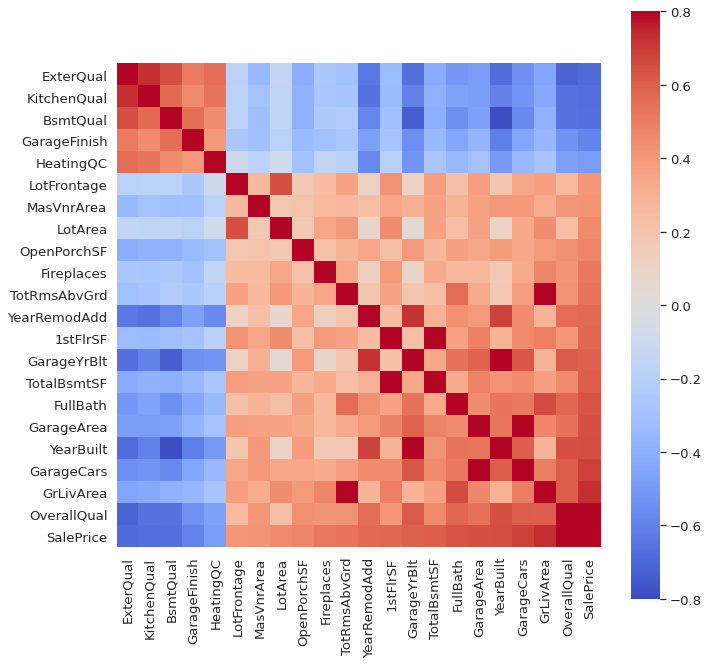

In [231]:
corrs = study_variable_correlations(train_derived, 0.4)

## Multi-colinearity

From the heatmap it is easy to pick out several features that are strongly rank correlated with each other:
- The quality metrics (OverallQual, ExterQual, KitchenQual, BsmtQual, HeatingQC)
- TotRmsAbvGrd and GrLivArea
- BsmtFinSF1 and BsmtFinType1
- GarageArea and GarageCars
- YearBuilt and GarageYrBlt

What should we do with the correlated features? In general, how does one deal with multi-collinearity? I have found people simply keep only one of the correlated features, or engineer new features that are combinations of the existing ones. One the one hand, multi-collinearity is known to cause large fluctuations in the values of the coefficients. On the other hand, it has also been suggested that removing multi-collinearity does not promise a significant improvement in prediction accuracy. Therefore, I did not spend much time engineering these features, at least before fitting the very first models.

Nevertheless, I use scatter plots to help examine the correlated features to see if I can find something interesting. Here I show one example plotting YearBuilt, GarageYrBlt and their relations with the sale price. For most houses the garage was built in the same year as the house, but there are exceptions where the garage was built later. Strangely, in rare cases, a garage was built way before the house itself (bugged data?).

Here is a nice explanation on multi-collinearity in regression analysis.
Ref: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/


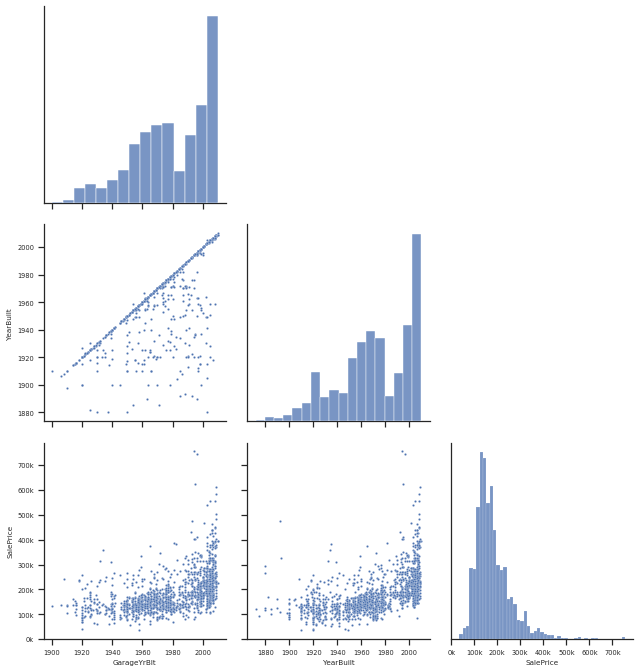

In [233]:
def pairplot_multi_variables(data, cols):
    '''
    Show paired scatter plot for selected features from the dataset.
    
    Parameters:
    ---
    data: The pd.DataFrame that contains the data.
    cols: A list of features (columns) from the dataset to plot.
    '''
    
    sns.set(style="ticks", font_scale=0.6)
    p = sns.pairplot(data[cols], height=1.5, corner=True, plot_kws={"s":5})
    p.fig.set_size_inches(10., 10.)
    # can use kind="hist"
    sns.despine()
    # Set corner to True to reduce resource consumption
    # Re-set tick labels for SalePrice
    for ax in p.axes.reshape(-1):
        if(ax == None): continue          
        if(ax.get_xlabel() == 'SalePrice'):
            ticks_loc = ax.get_xticks().tolist()
            ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
            xlabels = ['{:,.0f}'.format(x/1000) + 'k' for x in ticks_loc]
            ax.set_xticklabels(xlabels)
        if(ax.get_ylabel() == 'SalePrice'):
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
            ylabels = ['{:,.0f}'.format(y/1000) + 'k' for y in ticks_loc]
            ax.set_yticklabels(ylabels)
    return p

p = pairplot_multi_variables(train, ['GarageYrBlt', 'YearBuilt', 'SalePrice'])

Now let's move on to the nominal categorical features. 

First of all, note that there is a 'numerical' feature, 'MSSubClass', that is actually a nominal feature. So we need to label it accordingly

In [152]:
train_derived['MSSubClass'] = train_derived['MSSubClass'].astype('object')

## Norminal Features

### Cardinality
 
One thing to check is the cardinality of a categorical feature. Cardinality measures the number of unique categories for a feature. High cardinality variables, e.g., zip code, may pose serious challenges to training algorithms if they are encoded with dummy variables as it may drastically expands the feature space and thus introducing the curse of dimensionality. Alternatively, one might consider encode high cardinality variables with continuous numerics based on how they correlate with the target variable.

Reference: https://www.kdnuggets.com/2016/08/include-high-cardinality-attributes-predictive-model.html

The following code displays the 10 nominal features with highest cardinality. 

In [153]:
vars_cat = train_derived.select_dtypes('object')
# Drop features that are sparse
for var in vars_sparse.columns: 
    if(var in vars_cat):
        vars_cat = vars_cat.drop(var, axis=1)
# Find the number of unique values in any feature (cardinality)
ratio_unique = vars_cat.nunique() / vars_cat.count()
count_unique = vars_cat.nunique()
# sns.ecdfplot(ratio_unique)
# The 10 features with the most unique values
# One may want to avoid OneHot for very high cardinality columns
print("Features with largest number of unique values: ")
print("----------------")
# pandas guide says nlargest() is faster than sort_values().head(), so keep a good habit
print(count_unique.nlargest(10))

Features with largest number of unique values: 
----------------
Neighborhood    25
Exterior2nd     16
MSSubClass      15
Exterior1st     15
Condition1       9
SaleType         9
Condition2       8
HouseStyle       8
RoofMatl         8
Functional       7
dtype: int64


The feature with highest cardinality here is the "neighborhood", which has 25 distinct categories. This is manageable with the popular OneHot encoder, though I will experiment with target encoder and leave one out encoder later on some of the nominal features.

### Target response to nominal features

Next let's visualize the dependence of the target variable on the nominal features using boxplots. Below is a script that display many of these features on a self-adjusting grid.

In [234]:
def boxplot_multi_variables(cols, height=2.5, max_features=16, fignum="boxplot_multi", rank=False):
    '''
    Show the dependence of the target variable on multiple categorical variables.
    
    Parameters:
    ---
    cols: List of columns (features) to show. The total number of features must be smaller than max_features
    max_features: The maximum number of features to show (default: 4x4).
    height: Scale factor for the image size.
    rank: If True, rank order the labels on the x axis by the mean value.
    '''
    
    num_features = len(cols)
    if (num_features > max_features):
        raise ValueError("Too many features (%d, limit=%d) to show." % (num_features, max_features))
    # Optimize the number of rows/cols for plotting
    nrows = int(np.sqrt(num_features))
    if(nrows * (nrows + 1) < num_features): nrows += 1
    ncols = int(np.ceil(num_features / nrows))
    print("Plotting %d x %d grid for %d features ..." % (nrows, ncols, num_features))
    fig, axs = plt.subplots(nrows, ncols, num=fignum, figsize=(ncols*height, nrows*height*1.2), sharey=True)
    for i, ax in enumerate(axs.flatten()):
        if(i < num_features):
            if(rank):
                xy = train[[cols[i],'SalePrice']]
                sorted_index = xy.groupby(cols[i]).mean().sort_values(by='SalePrice',ascending=False).index
                sns.boxplot(data=train, x=cols[i], y="SalePrice", ax=ax, order=sorted_index)
            else:
                sns.boxplot(data=train, x=cols[i], y="SalePrice", ax=ax)
        if(i % nrows): ax.set_ylabel("")
        else:
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
            ylabels = ['{:,.0f}'.format(y/1000) + 'k' for y in ticks_loc]
            ax.set_yticklabels(ylabels)
        xlabel = ax.get_xlabel()
        ax.text(0.95, 0.9, xlabel, transform=ax.transAxes, ha='right',fontsize=height*3)
        ax.set_xlabel("")
    fig.subplots_adjust(hspace=0.2, wspace=0, top=0.9)
    return fig, axs


In [235]:
# Check how many nominal variables we have.
print(vars_cat.columns)
print("Number of nominal features: %d" % (vars_cat.columns.size))

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
       'Electrical', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')
Number of nominal features: 25


Plotting 3 x 3 grid for 9 features ...


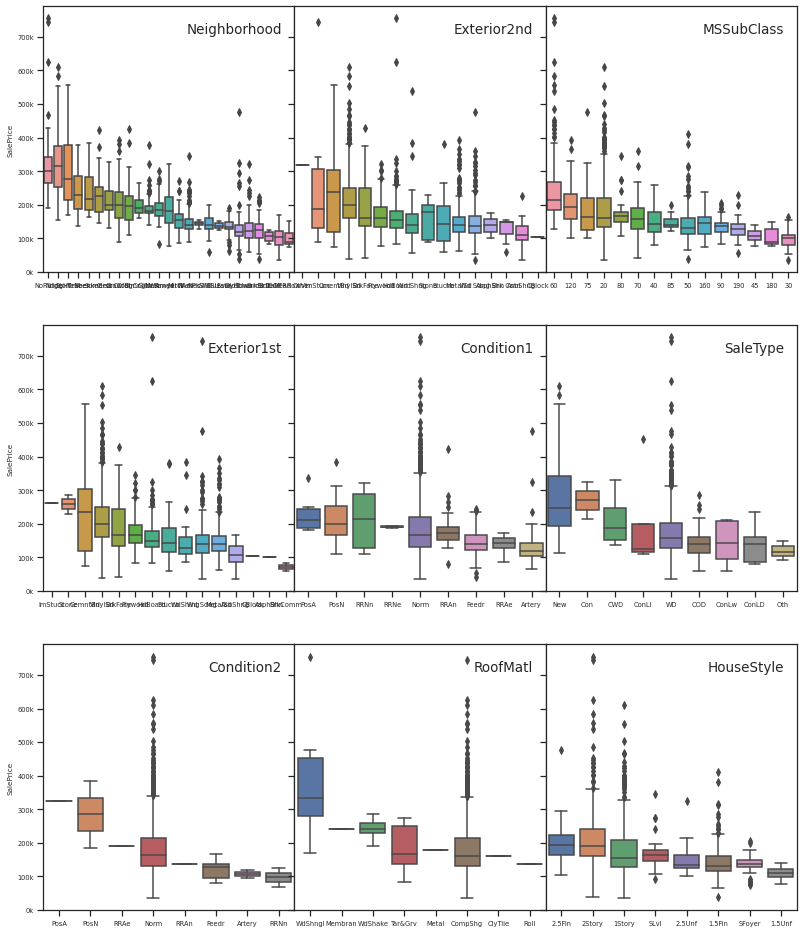

In [236]:
#_, _ = boxplot_multi_variables(vars_cat.columns[:16], height=3.5, rank=True)
_, _ = boxplot_multi_variables(count_unique.sort_values(ascending=False).index[:9], height=4.5, rank=True)

The above figure shows the 9 nominal features with highest cardinality. The features on the x-axis have been re-ordered by the mean of each category. From this figure it is easy to see:
1. Whether or not there is some intrinsic correlations between any feature and the target.
2. Where are the outliers and do they show any characteristics?

Clearly, several features, e.g., Neighborhood, Exterior1st, Exterior2nd, MSSubClass, do show strong correlations with the target value.

Now showing the rest of features:

Plotting 4 x 4 grid for 16 features ...


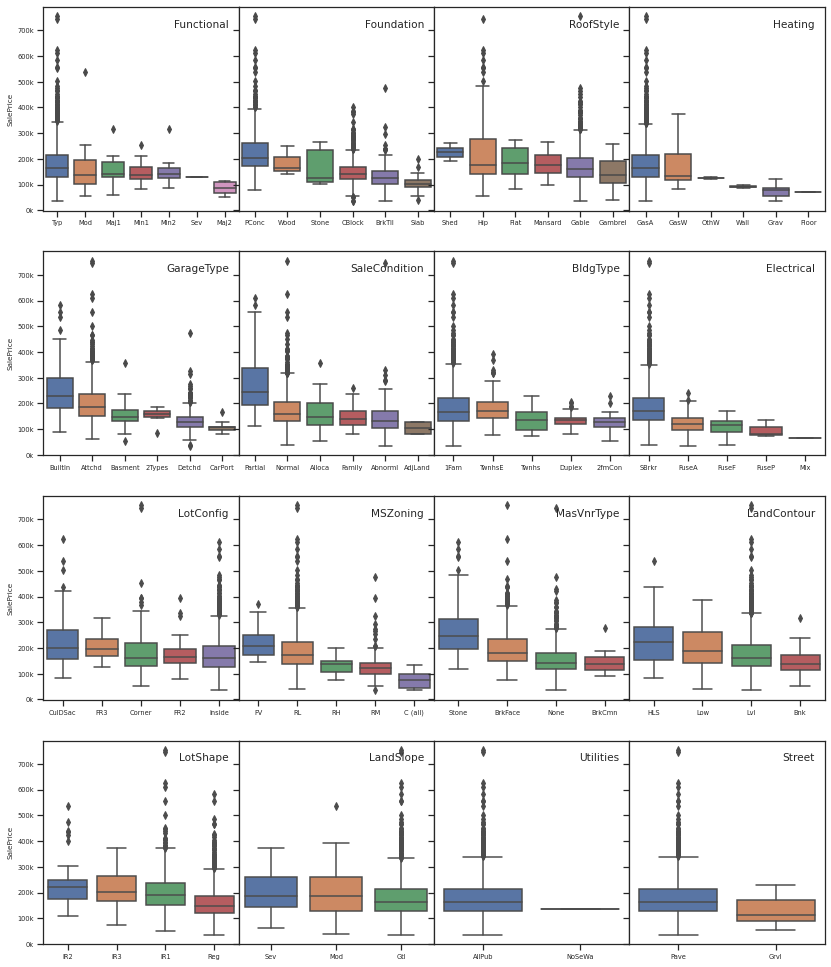

In [157]:
_, _ = boxplot_multi_variables(count_unique.sort_values(ascending=False).index[9:], height=3.5, rank=True)

None of these seem to show strong correlations with the target. In particular, note that the 'Utilities' only have value for one of its categories. We might drop it from the dataset.

### Encoding High Cardinality Features

Now let's revisit the problem of encoding high cardinality features such as the 'Neighborhood'. Here I tried a TargetEncoder and a LeaveOneOutEncoder, both re-labels the nominal categories with numerics based on how strong indicators these categories are.

Quote from the reference:
“features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

Reference: https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

One caveat, however, is that this kind of encoding should be applied to each train/cv split separately. Otherwise the trained model will under-estimate the cross validation error since the encoder itself already 'peeks' into the cv set. In other word, one should not apply the TargetEncoder to the whole dataset first and then perform train/cv split.

In [158]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

/home/shuiyao/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/shuiyao/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


    Neighborhood  TargetEncoder
23       MeadowV   98576.479855
21        IDOTRR  100123.783784
225       BrDale  104493.773379
9        BrkSide  124834.051724
39       Edwards  128219.700000
8        OldTown  128225.300885
10        Sawyer  136793.135135
267        SWISU  142591.360001
126      NPkVill  142707.263791
14         NAmes  145847.080000
599      Blueste  149177.758140
5        Mitchel  156270.122449
18       SawyerW  186555.796610
7         NWAmes  189050.068493
50       Gilbert  192854.506329
219      Blmngtn  194870.880783
0        CollgCr  197965.773333
3        Crawfor  210624.725490
69       ClearCr  212565.428571
6        Somerst  225379.837209
1        Veenker  238770.100937
41        Timber  242247.447368
58       StoneBr  310498.999995
11       NridgHt  316270.623377
4        NoRidge  335295.317073


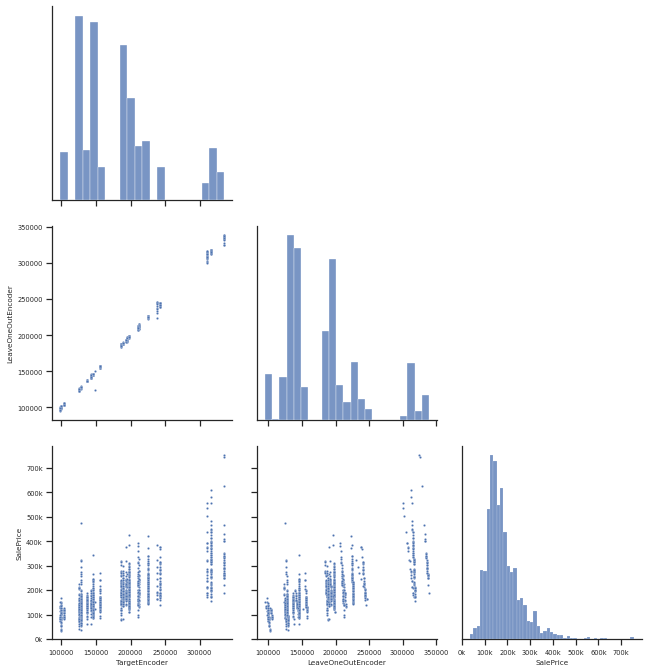

In [237]:
te_features = ['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MSSubClass']

te = TargetEncoder(cols=te_features)
looe = LeaveOneOutEncoder(cols=te_features)

x = te.fit_transform(train_derived, train_derived['SalePrice'])
x2 = looe.fit_transform(train_derived, train_derived['SalePrice'])

neighborhood = pd.DataFrame({'Neighborhood':train_derived['Neighborhood'], \
                             'TargetEncoder':x['Neighborhood'], \
                             'LeaveOneOutEncoder':x2['Neighborhood'], \
                             'SalePrice':train_derived['SalePrice']})

# Mapping between neighborhood and the encoded value
print(neighborhood[['Neighborhood','TargetEncoder']].drop_duplicates().sort_values(by='TargetEncoder'))

# Compare the re-labeled 'Neighborhood' feature using scatter plot
pairplot_multi_variables(neighborhood, neighborhood.columns)

As expected, some neighborhoods are more expensive than others!

## A Simple Random Forest Model

Finally, let's evaluate feature importance with a simple random forest model fit to the data.

In [206]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg_rf = RandomForestRegressor()


In [201]:
# Re-define train_derived
train_derived = train.copy()

# Drop features that will not be used in modeling
# Combines features that would be dropped:
drop_features = ["Id","Utilities"]
drop_features += vars_sparse.columns.tolist()
drop_features += vars_leaky
# drop_features += vars_collinear
for var in drop_features:
    if(var in train_derived):
        print("Drop feature: ", var)
        train_derived = train_derived.drop(var, axis=1)

# Hard code the ordinal features using a .json file
with open('ordinal.json',) as f:
    ordinal_feature_encoder = json.load(f)
train_derived = train_derived.replace(ordinal_feature_encoder)

# MSSubClass is a nominal (categorical) feature but is encoded with numerics
train_derived['MSSubClass'] = train_derived['MSSubClass'].astype('object')

# Prepare data for training
y = train_derived['SalePrice']
X = train_derived.drop('SalePrice', axis=1)

num_features = X.select_dtypes(['int', 'float']).columns
cat_features = X.select_dtypes('object').columns
ord_features = pd.Index(ordinal_feature_encoder.keys()).join(X.columns, how='inner') # Note that some features have been dropped in X.

Drop feature:  Id
Drop feature:  Utilities
Drop feature:  Alley
Drop feature:  PoolQC
Drop feature:  Fence
Drop feature:  MiscFeature
Drop feature:  MoSold
Drop feature:  YrSold
Drop feature:  SaleType
Drop feature:  SaleCondition


In [240]:
# Construct pipelines

# Replace missing values with mean, and perform standard scaler to numerical features.
# Note that the ordinal features are now numerical.
ppl_num = Pipeline(steps = \
    [('imp_num', SimpleImputer()), \
     ('scaler', StandardScaler())] \
)

# Apply OneHotEncoder to the remaining categorical features.
ppl_cat = Pipeline(steps = \
    [('imp_cat', SimpleImputer(strategy='constant', fill_value='missing')), \
     ('ohe', OneHotEncoder(handle_unknown='ignore'))] \
)
# Must set handle_unknown, otherwise when applying to test data error may occur:
# "found unknown categories in column ... during transform"

ct = ColumnTransformer(transformers= \
    [('numeric', ppl_num, num_features), \
     ('categorical', ppl_cat, cat_features)] \
)


In [208]:
# Train/Test split and perform the fit
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=120)

ppl_rf = Pipeline(steps = [('ct', ct), ('rf', reg_rf)])
ppl_rf.fit(X_train, y_train)
y_pred = ppl_rf.predict(X_test)

# First, check score to see if the fitted model is reasonable
print("RMSE score (RandomForest): %f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score (RandomForest): %f" % (ppl_rf.score(X_test, y_test)))

RMSE score (RandomForest): 28526.732743
r2 score (RandomForest): 0.877537


## Feature Importance

Not too bad! Now we are ready to evaluate feature importance from the random forest model.

But, how to extract feature importance from the fitted model? In simpler applications, the model has attributes such as coef_ and feature_importance_ that directly estimates the importance of any given feature. However there are two concerns: 
1. The feature_importance_ may not apply to the test set, because it is often estimated based solely on the training data which the model may overfit. 
2. It is hard to map the feature_importance_ metric to the original features if the data has gone through some transformations such as the OneHotEncoder for categorical features, which expands the feature space.

permuation_importance() provides a very convenient way of evaluating the feature importance on a hold-out test set. However, the results may be degraded if many features are correlated.

In [245]:
# SLOW CELL
print("Analyzing feature importance using permutation method: ")

perm_result_train = permutation_importance(ppl_rf, X_train, y_train, n_repeats=10, random_state=24)

perm_result_test = permutation_importance(ppl_rf, X_test, y_test, n_repeats=10, random_state=24)
perm_sorted_idx = perm_result_test.importances_mean.argsort()[::-1]

Analyzing feature importance using permutation method: 


The following script rank orders and displays the most important features calculated from the permutation_importance()

The top 10 Numerical features:
             mean_train  std_train  mean_test  std_test       type
OverallQual    0.518093   0.024388   0.461182  0.033537  numerical
GrLivArea      0.134260   0.004297   0.095192  0.006740  numerical
BsmtFinSF1     0.028080   0.001734   0.018901  0.003351  numerical
TotalBsmtSF    0.027884   0.001439   0.017012  0.001709  numerical
LotArea        0.017751   0.001062   0.006957  0.001563  numerical
GarageCars     0.017269   0.000975   0.012726  0.001801  numerical
1stFlrSF       0.016187   0.000425   0.008886  0.001482  numerical
GarageArea     0.012861   0.000890   0.003581  0.001823  numerical
2ndFlrSF       0.009845   0.000417   0.003687  0.000418  numerical
YearBuilt      0.005797   0.000389   0.003817  0.000904  numerical

The top 5 Nominal features (nominal):
              mean_train  std_train  mean_test  std_test     type
Neighborhood    0.004276   0.000464   0.002425  0.000652  nominal
GarageType      0.003495   0.000239   0.001312  0.000857  nom

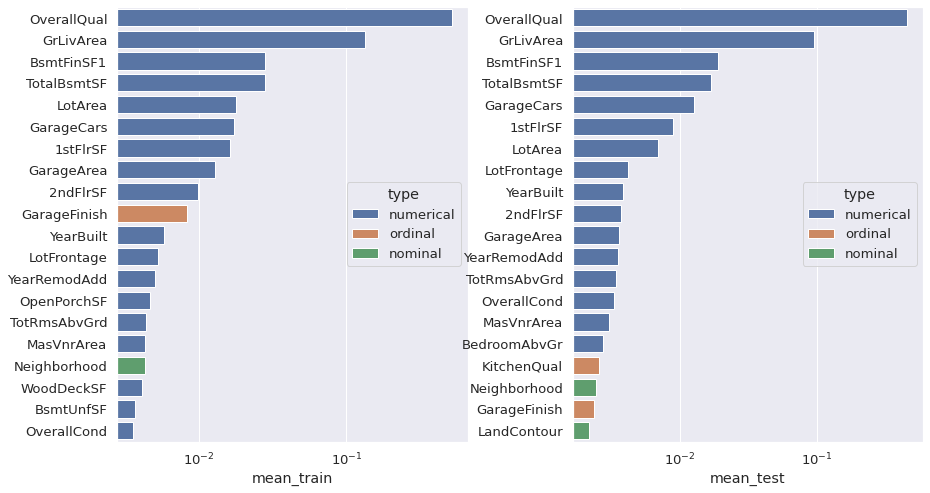

In [250]:
def show_important_features(perm_result_train, perm_result_test, X):
    '''
    Display the most important features calculated from the permutation method.

    Parameters:
    ---
    perm_result_train: The output from sklearn.inspection.permutation_importance on the training set
    perm_result_test: On the test set
    X: The training/test data before applying any pipeline. It is used to extract the features.
    '''
    types = ['N/A'] * X.columns.size
    feature_importance = pd.DataFrame({'mean_train':perm_result_train.importances_mean, \
                                       'std_train':perm_result_train.importances_std, \
                                       'mean_test':perm_result_test.importances_mean, \
                                       'std_test':perm_result_test.importances_std, \
                                       'type':types}, \
                                      index=X.columns)
    feature_importance.loc[num_features, 'type'] = 'numerical'
    feature_importance.loc[cat_features, 'type'] = 'nominal'
    feature_importance.loc[ord_features, 'type'] = 'ordinal'
    feature_importance.sort_values(by='mean_train', ascending=False, inplace=True)

    print("The top 10 Numerical features:")
    print(feature_importance[feature_importance['type']=='numerical'][:10])
    print()
    print("The top 5 Nominal features (nominal):")
    print(feature_importance[feature_importance['type']=='nominal'][:5])
    print()
    print("The top 5 Nominal features (ordinal):")
    print(feature_importance[feature_importance['type']=='ordinal'][:5])

    sns.set(font_scale = 1.2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), num='feature_importance')
    sns.barplot(x = feature_importance['mean_train'][:20], \
                y = feature_importance.index[:20], \
                hue=feature_importance['type'][:20], \
                ax=ax1, orient='h', dodge=False)
    
    feature_importance.sort_values(by='mean_test', ascending=False, inplace=True)
    
    sns.barplot(x = feature_importance['mean_test'][:20], \
                y = feature_importance.index[:20], \
                hue=feature_importance['type'][:20], \
                ax=ax2, orient='h', dodge=False)
    ax1.set_xscale("log")
    ax2.set_xscale("log")

    fig.subplots_adjust(left=0.2, wspace=0.30)
    plt.show()

show_important_features(perm_result_train, perm_result_test, X)

The numerical features explain most of the trend in the dependent variable y in both the training and the test set. The rank order is consistent with the correlation heatmap shown earlier. Though many of the features here are correlated, we can identify some of the strongest indicators for the sale price are:
- Quality (most notably the OverallQual)
- Area (above ground, basement, garage, etc.)
- Age (YearBuilt)

The 'Neighborhood' turns out as the most important nominal feature.

## Summary

Here it is! We have a metric that measures the permutation importance of all the features on the train/test dataset. In this notebook I have explored various topics of explorative data analysis using a house price dataset with more than 70 features and have made a plan of selecting and transforming features for further modeling with more sophisticated algorithms. Here is a summary of main conclusions and the pre-processing steps:
1. The target distribution is skewed. Perform log(1+x) transformation before modeling.
2. Drop several features from both the training and test set
  - 'Id': non-informative
  - 'Utilities': single-valued
  - 'PoolQC', 'Alley', 'Fence', 'MiscFeature': Very sparse with more than 80% data missing.
  - 'MoSold', 'YrSold', 'SaleType', 'SaleCondition': Likely leaky, maybe missing in the test set
3. One feature, 'MSSubClass', is falsely interpreted as numerical. Treat it as categorical.
4. Hard encode all ordinal features using input from a separate .json file.
5. Correlation heatmap shows strong signs of co-linearity, e.g., among the quality metrics. 
6. Several nominal features have more than 10 categories, among these features, the 'Neighborhood' shows signs of correlation with the target. Encode it using TargetEncoder.
7. Transform numerical features with a mean imputer and a standard scaler
8. Transform nominal features except 'Neighborhood' with OneHot Encoder ignoring missing values.
9. Train a random forest model and use it to evaluate feature importance on the test data using permutation.

In [253]:
vars_leaky

['MoSold', 'YrSold', 'SaleType', 'SaleCondition']